In [1]:
# import argparse
import torch
import torch.nn as nn

from sklearn.cluster import KMeans
import numpy as np
import torch.optim as optim
from sklearn import metrics
from tqdm import tqdm

from util import load_data, load_graph
from models.udci import U_DCI
from models.clf_model import Classifier

In [2]:
def setup_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


In [3]:
def finetune(config_udci, config_emb, model_pretrain, device, test_graph, feats_num, model):
    # model = Classifier(config_udci['emb_module'], config_udci['hidden_dim'], config_udci['final_dropout'], config_emb, device).to(device)
    # emb_module, hidden_dim, final_dropout, config_emb
    # replace the encoder in joint model with the pre-trained encoder，把外面训练好的CDI导进来，这个视角encoder吗
    # pretrained_dict = model_pretrain.state_dict()   # state_dict()是pytorch里调用所有参数信息的函数，这里是把DCI的参数信息存起来
    # model_dict = model.state_dict() #这里就是吧Classifier的参数信息存起来
    # pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}    # 只留下Classifier里有的字段的DCI的参数信息，为了防止下一步错叭
    # model_dict.update(pretrained_dict)  # 这两步就是把Classifier的参数信息更新成DCI的参数信息
    # model.load_state_dict(model_dict)

    optimizer = optim.Adam(model.parameters(), config_udci['lr'])  # 优化器的意思应该是反向传播的那个，不要纠结细节上次学过了虽然我知道你忘了
    
    criterion_tune = nn.BCEWithLogitsLoss() # 二分类的交叉熵损失函数

    res = []
    train_idx = test_graph[2]
    node_train = test_graph[-1][train_idx, 0].astype('int')
    label_train = torch.FloatTensor(test_graph[-1][train_idx, 1]).to(device)
    progress_bar2 = tqdm(total = config_udci['finetune_epochs'])
    store_loss_finetune = []
    for i in range(1, config_udci['finetune_epochs']+1):  # 这一段应该就是在训练
        model.train()
        output = model(test_graph[0], test_graph[1])
        loss = criterion_tune(output[node_train], torch.reshape(label_train, (-1, 1)))
        store_loss_finetune.append(loss.item())
        
        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        progress_bar2.set_description(f'Epoch: {i}/{config_udci["finetune_epochs"]}')
        progress_bar2.update()
        
        # testing
    model.eval()    # 设成eval模式
    auc = evaluate(model, test_graph)
    res.append(auc)

    # return np.max(res), store_loss_finetune  # 返回最大的auc
    return np.max(res), store_loss_finetune

In [4]:
def evaluate(model, test_graph):
    output = model(test_graph[0], test_graph[1])    #预测结果，其中0和1分别是adj和features，顺序记得确认一下
    pred = sig(output.detach().cpu())   # 用激活函数压缩一下然后结果传到cpu上
    test_idx = test_graph[3]    # 这个idx具体指什么要看model，我猜是abnormal data的idx
    
    labels = test_graph[-1] # 那么labels我猜就是abnormal data的label
    print(test_idx.shape)
    print(labels[test_idx, 0].shape)
    pred = pred[labels[test_idx, 0].astype('int')].numpy()  # 不知道了这里回头再来看吧
    target = labels[test_idx, 1]
    
    false_positive_rate, true_positive_rate, _ = metrics.roc_curve(target, pred, pos_label=1)
    auc = metrics.auc(false_positive_rate, true_positive_rate)  # auc越接近1越好

    return auc

In [5]:
# set parameters for U_DCI
config_udci = {
    'dataset': 'wiki',              # name of dataset
    'device': 0,                    # which gpu to use if any
    'epochs': 0,                   # number of epochs in pre-training stage
    'num_cluster': 2,               # number of clusters in pre-training stage
    'recluster_interval': 20,       # recluster interval in pre-training stage
    'finetune_epochs': 200,         # number of epochs in finetune stage
    'num_folds': 1,                # number of folds in cross validation of finetune stage
    'final_dropout': 0.5,           # dropout rate used in finetune stage
    'lr': 0.001,                     # learning rate used in optimizer
    'hidden_dim': 16,               # number of hidden dims, used in Discriminator
    'training_scheme': 'decoupled', # 'decoupled' or 'joint'
    'emb_module': 'U_GCN'           # 'U_GCN', 'GIN'
}

In [6]:
# set hyperparameters for embedding module

#U_GCN
if config_udci['emb_module'] == 'U_GCN':
    config_emb = {
        # 'in_features': 64,      # number of initial feature dims, used in GraphAttention
        'out_features': 16,     # number of feature dims generated by one attention head, used in GraphAttention
        'alpha': 0.2,           # slope of leakyReLU, used in GraphAttention
        'final_features': 16,   # number of feature dims integrated out of all attention heads, used in GraphAttention
        'dropout': 0.6,         # customized dropout rate, used in GraphAttention & GAT
        'nheads': 8             # number of attetnion heads, used in GAT
        
    }

# GIN
elif config_udci['emb_module'] == 'GIN':
    config_emb = {
        'num_layers': 2,
        'num_mlp_layers': 2,
        'hidden_dim': 16,
        'neighbor_pooling_type': 'sum'
    }

In [7]:
sig = torch.nn.Sigmoid()
# setup_seed(0)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

edge_index, feats, split_idx, label, nb_nodes = load_data(config_udci['dataset'], config_udci['num_folds'], 0.8)
config_emb['input_dim'] = feats.shape[1]

kmeans = KMeans(n_clusters=config_udci['num_cluster'], random_state=0).fit(feats)
ss_label = kmeans.labels_
cluster_info = [list(np.where(ss_label==i)[0]) for i in range(config_udci['num_cluster'])]

idx = np.random.permutation(nb_nodes)
shuf_feats = feats[idx, :]

adj = load_graph(torch.LongTensor(edge_index), nb_nodes, config_udci['emb_module'], device)
feats = torch.FloatTensor(feats).to(device)
shuf_feats = torch.FloatTensor(shuf_feats).to(device)

Load the edge_index done!
Ratio of fraudsters:  0.026376564969004496
Number of edges:  18257
Number of users:  8227
Number of objects:  1000
Number of nodes:  9227
shape of train_idx: (6582,), shape of test_idx: (1645,)


c:\ProgramData\miniconda3\envs\DCI2\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
model_pretrain = U_DCI(config_udci['emb_module'], config_udci['hidden_dim'], config_emb, device).to(device)
optimizer_train = optim.Adam(model_pretrain.parameters(), lr=config_udci['lr'])

store_loss = []


In [9]:
# pre-training process
progress_bar = tqdm(total = config_udci['epochs'])
for epoch in range(1, config_udci['epochs'] + 1):
    model_pretrain.train()
    loss_pretrain = model_pretrain(feats, shuf_feats, adj, None, None, None, cluster_info, config_udci['num_cluster'])
    if optimizer_train is not None:
        optimizer_train.zero_grad()
        loss_pretrain.backward()         
        optimizer_train.step()
        store_loss.append(loss_pretrain.item())
    else:
        print(f'Optimizer is none. Current epoch: {epoch}')
    progress_bar.set_description(f'Epoch: {epoch}/{config_udci["epochs"]} | Current loss: {loss_pretrain.item():.3f}')
    progress_bar.update()
    
    # re-clustering
    if epoch % config_udci['recluster_interval'] == 0 and epoch < config_udci['epochs']:
        model_pretrain.eval()
        emb = model_pretrain.get_emb(feats, adj)
        kmeans = KMeans(n_clusters=config_udci['num_cluster'], random_state=0).fit(emb.detach().cpu().numpy())
        ss_label = kmeans.labels_
        cluster_info = [list(np.where(ss_label==i)[0]) for i in range(config_udci['num_cluster'])]

print(f'Pre-training Down!')

0it [00:00, ?it/s]

Pre-training Down!


In [10]:
#fine-tuning process
fold_idx = 1
every_fold_auc = []

model = Classifier(config_udci['emb_module'], config_udci['hidden_dim'], config_udci['final_dropout'], config_emb, device).to(device)

pretrained_dict = model_pretrain.state_dict()   # state_dict()是pytorch里调用所有参数信息的函数，这里是把DCI的参数信息存起来
model_dict = model.state_dict() #这里就是吧Classifier的参数信息存起来
pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}    # 只留下Classifier里有的字段的DCI的参数信息，为了防止下一步错叭
model_dict.update(pretrained_dict)  # 这两步就是把Classifier的参数信息更新成DCI的参数信息
model.load_state_dict(model_dict)

for (train_idx, test_idx) in split_idx: # split_idx在load data的时候就生成了
    print(f'shape of train_idx: {train_idx.shape}, shape of test_idx: {test_idx.shape}')
    test_graph = (feats, adj, train_idx, test_idx, label)
    tmp_auc, store_loss_finetune = finetune(config_udci, config_emb, model_pretrain, device, test_graph, config_emb['input_dim'], model)
    every_fold_auc.append(tmp_auc)
    print('AUC on the Fold'+str(fold_idx)+': ', tmp_auc)    # 会返回每种folder的auc，每个auc是模型优化后最好的auc（因为是max）
    fold_idx += 1
print('The averaged AUC score: ', np.mean(every_fold_auc))


shape of train_idx: (6582,), shape of test_idx: (1645,)


(1645,)
(1645,)


Epoch: 200/200: 100%|██████████| 200/200 [1:37:10<00:00, 29.15s/it]

AUC on the Fold1:  0.5
The averaged AUC score:  0.5


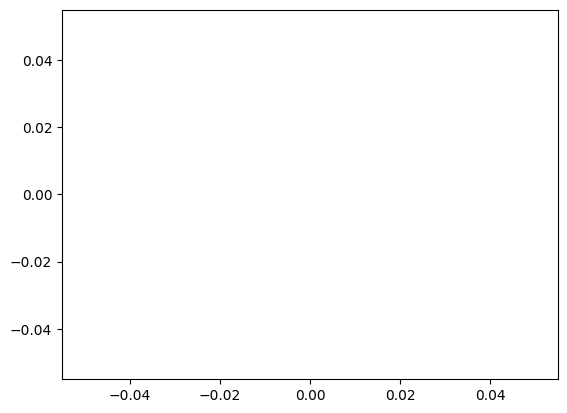

In [11]:
import matplotlib.pyplot as plt
plt.plot(store_loss)

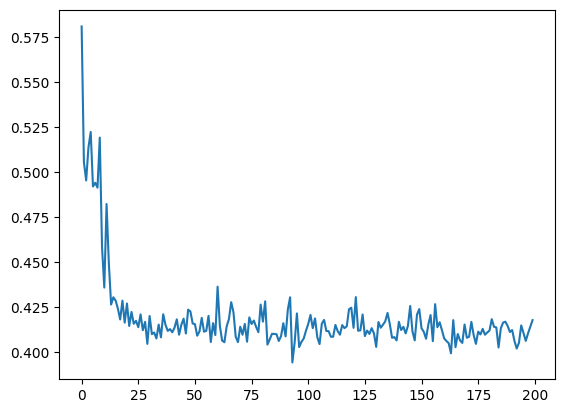

In [12]:
plt.plot(store_loss_finetune)

In [13]:
import random
test1 = [1,2,3,4]
test2 = [5,6,7,8,9,10,11,12]
test3 = []
test3.append(random.sample(test1,round(len(test1)* 0.2))+random.sample(test2, round(len(test2)* 0.2)))
test3

[[2, 9, 8]]